### Naive Bayes

This code implements the naive bayes on CIFAR-10 dataset with the naive assumption that the features are independent. Naive Baysean approach takes independent feature's probability and then combine them as given in the formula.

The naive Bayes classifier assumes that features mR, mG and mB are independent and therefore a class
specific posterior probability can be computed from...

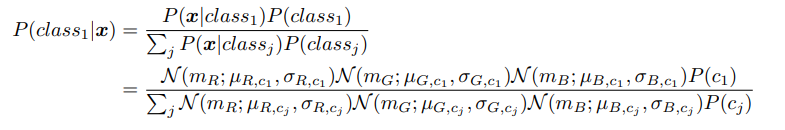



In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage import transform
from scipy.stats import norm
from scipy.stats import multivariate_normal

def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding="latin1")
    return dict

datadict_tst = unpickle(r'/cifar-10/test_batch') #Loads all unpickled raw Test data in datadict_tst variable

def Load_Data(Data_sets):
    LBL=[]
    for i in range(1, Data_sets+1):

        path='/cifar-10/data_batch_{}'.format(i)
        Load = unpickle(r'{}'.format(path))
        DAT=Load["data"]           
        LBL+=Load["labels"]
        if i == 1:           
            Da=Load["data"]           
        else:
            Da=np.vstack([Da, DAT])           
#    print("Data Shape:",Da.shape)
    LBL = np.array(LBL)
#    print("Label Shape:",LBL.shape)
    return Da,LBL


X1,Y=Load_Data(5) #Load All 5 data sets into X1 and Labels in Y
X_Pic = X1.reshape(X1.shape[0], 3, 32, 32).transpose(0,2,3,1).astype("float") #Reshape the 10K images into 3 32 X 32 grids. (for RGBs)
                                                                    #Now, transpose this with the given axis.

Q1a = datadict_tst["data"]
Q_Label = datadict_tst["labels"]

Q_Label = np.array(Q_Label)  ## contains class numbers for each image to tell which img belongs to which class
Q_TST_Pic = Q1a.reshape(Q1a.shape[0], 3, 32, 32).transpose(0,2,3,1).astype("float") #Reshape the 10K images into 3 32 X 32 grids. (for RGBs)
                                                                    #Now, transpose this with the given axis.

print('All Datasets Loaded')
print("X Dataset's Dimensions:" ,X_Pic.shape)
print("Q Test Dataset's Dimensions:" ,Q_TST_Pic.shape)

print('========================================================================')


All Datasets Loaded
X Dataset's Dimensions: (50000, 32, 32, 3)
Q Test Dataset's Dimensions: (10000, 32, 32, 3)


This Block calculates the class accuracy and also performs transformations on our data array. Since data image is 3072 byte long vector, we need to reshape each image to 1x1x3 format. Now, Images will be of only 1 pixel!

In [2]:
#%timeit -r1 -n1


def class_acc(pred,gt): #This function will compare the Labels that were predicted using any 
                        #classifier (such as Random or 1NN) to Original labels that came with dataset (our ground truth)
                        #and will give us an accuracy estimate of our program.
    err=0            #will store number of mismatches
    accuracy=0          #wil be used to calculate accuracy
    for i in range(0,len(gt)): #Loop to iterate through all ground truth variables and compare with pred.
        if gt[i]!=pred[i]:     #comparing each Pred label to gt label
            err=err+1;         #increment the error counter

    accuracy=(len(pred)-err)/(len(pred)) #calculate the accuracy ((totalpts-error)/totalpts)*100(for %)
    accuracyPercentage=accuracy*100
    return accuracyPercentage

def cifar10_color(X):  #converts the original images in X (50000 ×32 ×32 ×3) to Xp (50000 ×3)
    
    resized_x = transform.resize(X, (X.shape[0], 1, 1, 3), order=1, mode='reflect', anti_aliasing=True).reshape(X.shape[0], 3)
    return resized_x

This block provides a helper function to sort all images according to their classes from 0 to 9. Since we know all classes have perfectly 5000 images, we can use this knowledge while calculating mean and variances in later sections.

In [3]:
def class_Sorter(Xs,Ys):
    values=[]
    print("Sorting Resized Images according to their Labels")
    for i in range(Xs.shape[0]): #run as many times as data pts in Xp array 
        values.append((Xs[i],Ys[i])) #mark all Scaled images with their Labels in single array with Y array (containing labels)      

    values = sorted(values,key = lambda x:x[1])
    values=np.asarray(values)[:,0]  #Fetch all values without class numbers (since they are already sorted and we know exact count...)
    values = np.stack( values, axis=0 )  #Combine arrays of all Images with columns representing R,G,B channels

    return values

This function block calculates the normal distribution parameters (mean, variance and priors) for all classes. For all ten classes (mu and sigma are 10 × 3 and priors p is 10 × 1).

In [4]:
def cifar_10_naivebayes_learn(X,Y):
    
    Sorted_values = class_Sorter(X,Y)              #Sorted images(order: 0-9 classes) without class labels
    result_Classes_MU = np.empty((0,3), float)
    result_Classes_Sigma_squared = np.empty((0,3), float)

    batch=5000  #max. number of sorted images per class.
    
    for i in range(0,len(Sorted_values),batch):
        #print("Process Images from", i, "to", batch+i)
        Channel_R = Sorted_values[i:batch+i , 0]
        Channel_G = Sorted_values[i:batch+i , 1]
        Channel_B = Sorted_values[i:batch+i , 2]

        meanR=np.mean(Channel_R) #Calculate mean of Red channel for current class[j]
        meanG=np.mean(Channel_G) #Calculate mean of Green channel for current class[j]
        meanB=np.mean(Channel_B) #Calculate mean of Green channel for current class[j]
        VarR=np.var(Channel_R)   #Calculate variance of Red channel for current class[j]
        VarG=np.var(Channel_G)   #Calculate variance of Green channel for current class[j]
        VarB=np.var(Channel_B)   #Calculate variance of Blue channel for current class[j]

        result_Classes_MU = np.append(result_Classes_MU, np.array([[meanR,meanG,meanB]]), axis=0)
        result_Classes_Sigma_squared = np.append(result_Classes_Sigma_squared, np.array([[VarR,VarG,VarB]]), axis=0)
    
    result_Classes_Prior = np.repeat(0.1, 10)  #create array containing 0.1 for 10 classes

    #print("MU's Shape",result_Classes_MU.shape)
    #print("MU's values",result_Classes_MU)
    #print("Sigma's Shape",result_Classes_Sigma.shape)
    #print("Sigma's values",result_Classes_Sigma)
    
    return result_Classes_MU, result_Classes_Sigma_squared, result_Classes_Prior




Using this formula, we calculate the probabilities.

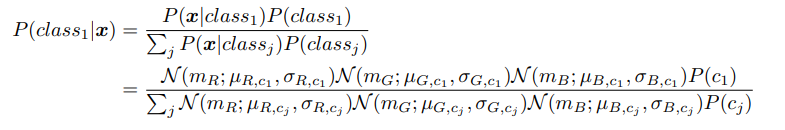

In [5]:

def Prob_dens(x,mean,sigSQ):
    #prob_density = ( 1/np.sqrt(2*np.pi*sigSQ) ) * ( np.exp( -1/(2*sigSQ) * ( (x-mean)**2 ) ) )
    prob_density = ( 1/np.sqrt(2*np.pi*sigSQ) ) * ( np.exp( -((x-mean)**2)/(2*sigSQ)) )
    
    #print("prob. Density is:",prob_density)
    return prob_density

def cifar10_classifier_naivebayes(tst,mu,sigmaSQ,p):
    Total_Dr=0.0
    all_NR=[]
    for i in range(0,10):
        Dr_Data = Prob_dens(tst,mu[i],sigmaSQ[i]) #calc PDF for one img
        
        #Dr_Data=norm.pdf(tst,mu[i],sigmaSQ[i])
        #print()
        #print("Class-",i)
        #print("Data",Dr_Data)
        #print("------------------------")
        
        Data = (Dr_Data[0]*Dr_Data[1]*Dr_Data[2])*p[i]  #multiply channel values with priors for this class
        
        Total_Dr = Total_Dr + Data  #Sum all denominator values to calculations from all other classes too.
        
        all_NR.append(Data)   #Numerator values for this class only...

    all_NR=np.asarray(all_NR)                  #Convert to array
    out = np.divide(all_NR, Total_Dr)          #Perform division
    Estimated_Img_class = out.argmax(axis=0)   #Perform estimation with max value.
    
    #print("Data: ",Data)
    #print("Total_Dr: ",Total_Dr)
    #print("all_NR: ",all_NR)
    #print("Outs: ",out)
    #print("Estimated_Img_class: ",Estimated_Img_class)
    
    return Estimated_Img_class


def batch_naivebayes(TST,Mew,sig,pri): #tst sample scaled img array containing test imgs.#MU, SIG, Prior calculated earlier
    Naive_labels=np.array([])
    for i in range(TST.shape[0]):
        OP=cifar10_classifier_naivebayes(TST[i],Mew,sig,pri)
        Naive_labels = np.append(Naive_labels,OP)
        #print(i) #Images processed
    #print("Predicted Label's Shape is: ",Naive_labels.shape) #verify the shape of predicted labels
    return Naive_labels  



**Run and Get accuracy**

In [7]:
#============================================================================ Resizing Images

RESIZE_1X1_DATA=cifar10_color(X_Pic)
RESIZE_1X1_TST=cifar10_color(Q_TST_Pic)
print("Resized Training Image's Dimensions:" ,RESIZE_1X1_DATA.shape)  
print("Resized Test Image's Dimensions:" ,RESIZE_1X1_TST.shape)  
print()

#========= Training Naive bayes to fetch Mu,Sigma etc..

print("#========= Training Naive bayes")
MU,SIG_SQ,PRIOR = cifar_10_naivebayes_learn(RESIZE_1X1_DATA,Y)
print("Naive MU's Shape",MU.shape)
print("Naive Sigma Squared's Shape",SIG_SQ.shape)
print("Naive Prior's Shape",PRIOR.shape)
print()

#========= RUNNING NAIVE BAYES AND FETCHING ACCURACY

print("#========= RUNNING NAIVE BAYES AND FETCHING ACCURACY")
BATCH_naive=batch_naivebayes(RESIZE_1X1_TST,MU,SIG_SQ,PRIOR)
BATCH_Acc=class_acc(BATCH_naive,Q_Label)      #Calculate accuracy % of this TEST data set by Comparing Predicted Labels to Ground truth labels 
print("Naive Accuracy in %: ",BATCH_Acc)
print()


Resized Training Image's Dimensions: (50000, 3)
Resized Test Image's Dimensions: (10000, 3)

#========= Training Naive bayes
Sorting Resized Images according to their Labels
Naive MU's Shape (10, 3)
Naive Sigma Squared's Shape (10, 3)
Naive Prior's Shape (10,)

#========= RUNNING NAIVE BAYES AND FETCHING ACCURACY
Naive Accuracy in %:  19.52

